for Financial Data

In [ ]:
pip install yfinance --upgrade --no-cache-dir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


for Sentiment Analysis


In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 85.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 87.4 MB/s eta 0:00:00


Imports

In [ ]:
import os
import pandas as pd
import numpy as np
import requests
import yfinance as yf
import matplotlib.pyplot as plt
import networkx as nx
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from transformers import pipeline
pipe = pipeline(model="facebook/bart-large-mnli")
#sentiment = pipeline("sentiment-analysis")

Fetching Stock Data

In [ ]:
stock_symbol = 'BAJAJFINSV'
nse = stock_symbol + '.NS'
ticker = yf.Ticker(nse)
data = yf.download(tickers=nse,period='12y',interval='1d') #last 5 years data with interval of 1 month

[*********************100%***********************]  1 of 1 completed


In [ ]:
data.reset_index(inplace=True)
data['Date'] = pd.to_datetime(data['Date'])

In [ ]:
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2954,2023-04-17,1345.000000,1352.949951,1330.550049,1341.150024,1341.150024,1073923
2955,2023-04-18,1340.000000,1348.699951,1329.000000,1335.199951,1335.199951,1236391
2956,2023-04-19,1335.000000,1338.949951,1322.050049,1331.349976,1331.349976,590360
2957,2023-04-20,1333.949951,1341.349976,1325.050049,1332.099976,1332.099976,467602
2958,2023-04-21,1336.500000,1338.000000,1306.550049,1317.900024,1317.900024,825513


Web scraping Fundamental Parameters of Stock

In [ ]:
url = f"https://www.screener.in/company/{stock_symbol}/consolidated/#profit-loss"

# Read the table from the website
dfs = pd.read_html(url)

# The first table on the page is the one we want
df = dfs[1]

# Print the table
print(df)

           Unnamed: 0 Mar 2011 Mar 2012 Mar 2013 Mar 2014 Mar 2015 Mar 2016  \
0             Sales +     2415     2715     8055     6023    11335    20533   
1          Expenses +      615      920     4124     1531     5823    13795   
2    Operating Profit     1800     1794     3931     4491     5511     6739   
3               OPM %      75%      66%      49%      75%      49%      33%   
4      Other Income +      168     1190        2        3        8        0   
5            Interest      301      744     1204     1562     2230     2877   
6        Depreciation       19       14       22       31       38       58   
7   Profit before tax     1649     2226     2708     2902     3251     3804   
8               Tax %      11%      15%      18%      24%      26%      27%   
9          Net Profit     1492     1890     2214     2191     2409     2775   
10          EPS in Rs     7.00     8.40     9.89     9.71    10.62    11.71   
11  Dividend Payout %       2%       2%       2%    

In [ ]:
# Extract the Net Profit data
profit = df.loc[9, 'Mar 2011':'Mar 2022']
profit.to_csv(f"{stock_symbol}profit.csv")
profit = pd.read_csv(f'/content/{stock_symbol}profit.csv')
profit = profit.rename(columns={profit.columns[0]: 'year', profit.columns[1]: 'profit'})

#profit.year = profit.year.str.replace('Mar ', '')

profit['year'] = pd.to_datetime(profit['year'])


# Print the Net Profit data
print(profit)

         year  profit
0  2011-03-01    1492
1  2012-03-01    1890
2  2013-03-01    2214
3  2014-03-01    2191
4  2015-03-01    2409
5  2016-03-01    2775
6  2017-03-01    3450
7  2018-03-01    4176
8  2019-03-01    5374
9  2020-03-01    5994
10 2021-03-01    7367
11 2022-03-01    8314


In [ ]:
# convert date column to datetime format
data['date'] = pd.to_datetime(data['Date'])

# create a dictionary to map year-month pairs in df1 to profit values in df2
profits = dict(zip(profit['year'].dt.strftime('%Y-%m'), profit['profit']))

# initialize an empty list to store profit_new values for each row in df1
profit_new = []

# initialize the profit_value variable to NaN
profit_value = float('nan')

# loop through each row in df1
for i, row in data.iterrows():
    
    # get the year-month string for the current row in df1
    year_month = row['date'].strftime('%Y-%m')
    
    # check if the year-month string is in the profits dictionary
    if year_month in profits:
        # if it is, assign the corresponding profit value to the current row in df1
        profit_value = profits[year_month]
    
    # append the current value of profit_value to the profit_new list
    profit_new.append(profit_value)

# add the profit_new column to df1
data['fundamental'] = profit_new

data = data.drop(columns=['date'])
# print the resulting dataframe
data

,Date,Open,High,Low,Close,Adj Close,Volume,fundamental
0,2011-04-21,51.230534,54.114063,51.230534,52.851597,52.168812,2798731,NaN
1,2011-04-25,53.053001,54.423538,52.414402,53.097214,52.411259,3275420,NaN
2,2011-04-26,51.333694,53.789852,51.333694,52.753353,52.071838,2599273,NaN
3,2011-04-27,53.053001,53.642483,52.070541,53.053001,52.367611,1951310,NaN
4,2011-04-28,53.441074,54.182835,52.679668,53.863537,53.167679,2827271,NaN
...,...,...,...,...,...,...,...,...
2954,2023-04-17,1345.000000,1352.949951,1330.550049,1341.150024,1341.150024,1073923,8314.0
2955,2023-04-18,1340.000000,1348.699951,1329.000000,1335.199951,1335.199951,1236391,8314.0
2956,2023-04-19,1335.000000,1338.949951,1322.050049,1331.349976,1331.349976,590360,8314.0
2957,2023-04-20,1333.949951,1341.349976,1325.050049,1332.099976,1332.099976,467602,8314.0


In [ ]:
trend = []
previous = 0
for index, row in data.iterrows():
    current = row['fundamental']
    if current > previous:
        trend.append(2)
    elif current < previous:
        trend.append(0)
    else:
        if not trend:
            trend.append(1)
        else:
            trend.append(trend[-1])
    previous = current
data['fund'] = trend
data


,Date,Open,High,Low,Close,Adj Close,Volume,fundamental,fund
0,2011-04-21,51.230534,54.114063,51.230534,52.851597,52.168812,2798731,NaN,1
1,2011-04-25,53.053001,54.423538,52.414402,53.097214,52.411259,3275420,NaN,1
2,2011-04-26,51.333694,53.789852,51.333694,52.753353,52.071838,2599273,NaN,1
3,2011-04-27,53.053001,53.642483,52.070541,53.053001,52.367611,1951310,NaN,1
4,2011-04-28,53.441074,54.182835,52.679668,53.863537,53.167679,2827271,NaN,1
...,...,...,...,...,...,...,...,...,...
2954,2023-04-17,1345.000000,1352.949951,1330.550049,1341.150024,1341.150024,1073923,8314.0,2
2955,2023-04-18,1340.000000,1348.699951,1329.000000,1335.199951,1335.199951,1236391,8314.0,2
2956,2023-04-19,1335.000000,1338.949951,1322.050049,1331.349976,1331.349976,590360,8314.0,2
2957,2023-04-20,1333.949951,1341.349976,1325.050049,1332.099976,1332.099976,467602,8314.0,2


In [ ]:
# data.to_csv('data.csv')
# from google.colab import files
# files.download('data.csv') 

Calculating Technical Parameters of stock

In [ ]:
def get_wr(High, Low, Close, lookback):
    highh = High.rolling(lookback).max() 
    lowl = Low.rolling(lookback).min()
    wr = -100 * ((highh - Close) / (highh - lowl))
    return wr

data['technical'] = get_wr(data['High'], data['Low'], data['Close'], 14)
data = data.dropna()

def assign_value(x):
    if x > -10:
        return 4
    elif x >= -20 and x <= -10:
        return 3
    elif x >= -90 and x <= -80:
        return 1
    elif x < -90:
        return 0
    else:
        return 2

def assign_values(y):
    if y > -10:
        return "strong buy"
    elif y >= -20 and y <= -10:
        return "buy"
    elif y >= -90 and y <= -80:
        return "sell"
    elif y < -90:
        return "strong sell"
    else:
        return "neutral"

data['tech'] = data['technical'].apply(assign_value)

t = data['tech'].iat[-1]
data['signal'] = data['technical'].apply(assign_values)
t = data['signal'].iat[-1]
data

<ipython-input-12-54a1fa9b91a1>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tech'] = data['technical'].apply(assign_value)
<ipython-input-12-54a1fa9b91a1>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['signal'] = data['technical'].apply(assign_values)


,Date,Open,High,Low,Close,Adj Close,Volume,fundamental,fund,technical,tech,signal
213,2012-03-01,63.329567,65.323967,59.173748,62.602543,61.943157,5647296,1890.0,1,-24.737767,2,neutral
214,2012-03-02,61.895172,63.172375,59.940067,62.263596,61.607784,1921629,1890.0,1,-26.245624,2,neutral
215,2012-03-05,62.386402,63.270618,61.502186,61.585693,60.937023,1012068,1890.0,1,-36.033377,2,neutral
216,2012-03-06,60.912708,64.154839,59.576557,59.871296,59.240673,1360183,1890.0,1,-47.203588,2,neutral
217,2012-03-07,59.537258,60.215160,59.080414,59.330940,58.706017,545364,1890.0,1,-50.848427,2,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...
2954,2023-04-17,1345.000000,1352.949951,1330.550049,1341.150024,1341.150024,1073923,8314.0,2,-8.553774,4,strong buy
2955,2023-04-18,1340.000000,1348.699951,1329.000000,1335.199951,1335.199951,1236391,8314.0,2,-12.866985,3,buy
2956,2023-04-19,1335.000000,1338.949951,1322.050049,1331.349976,1331.349976,590360,8314.0,2,-15.657835,3,buy
2957,2023-04-20,1333.949951,1341.349976,1325.050049,1332.099976,1332.099976,467602,8314.0,2,-15.114159,3,buy


In [ ]:
# data.to_csv('data.csv')
# from google.colab import files
# files.download('data.csv') 

Web scraping News of stock

In [ ]:
import requests
from bs4 import BeautifulSoup

base_url = 'https://www.moneycontrol.com/stocks/company_info/stock_news.php'
sc_id = 'BF04'

# get all the available year links
response = requests.get(f'{base_url}?sc_id={sc_id}&durationType=Y')
soup = BeautifulSoup(response.content, 'html.parser')
year_links = soup.find('div', {'class': 'FR yrs'}).find_all('a')

for year_link in year_links:
    year = year_link.text.strip()
    year_url = year_link.get('href')
    
    # get the number of pages for the year
    response = requests.get(f'{base_url}{year_url}')
    soup = BeautifulSoup(response.content, 'html.parser')
    #num_pages = soup.find('div', {'class': 'pages MR10 MT15'}).find_all('a')[-1].text
    num_pages_links = soup.find('div', {'class': 'pages MR10 MT15'}).find_all('a')
    if num_pages_links:
      num_pages = num_pages_links[-1].text
    else:
      num_pages = '1'
    
    # fetch all links for the year and pages
    for page in range(1, int(num_pages) + 1):
        news_url = f'{base_url}?sc_id={sc_id}&scat=&pageno={page}&next=0&durationType=Y&Year={year}&duration=1&news_type='
        response = requests.get(news_url)
        soup = BeautifulSoup(response.content, 'html.parser')
        news_links = soup.find_all('a', {'class': 'g_14bl'})
        
        for news_link in news_links:
           strong_tag = news_link.find('strong')
           news = strong_tag.text
           print(news)

Buy Bajaj Finserv; target of Rs 1650: Sharekhan
Buy Bajaj Finserv; target of Rs 1625: ICICI Direct
Bajaj Finserv Consolidated December 2022 Net Sales at Rs 21,755.15 crore, up 23.7% Y-o-Y
Bajaj Finserv Consolidated December 2022 Net Sales at Rs 21,755.15 crore, up 23.7% Y-o-Y
Bajaj Finserv Standalone December 2022 Net Sales at Rs 32.84 crore, down 85.21% Y-o-Y
A bull run in the making? Experts frame top 10 trading ideas for next 3-4 weeks
Buy Bajaj Finserv; target of Rs 1950: Sharekhan
Hold Bajaj Finserv; target of Rs 1850: ICICI Direct
Hold Bajaj Finserv; target of Rs 1850: ICICI Direct
Buy Bajaj Finserv; target of Rs 17,800: Sharekhan
Buy Bajaj Finserv; target of Rs 17600: ICICI Direct
Buy Bajaj Finserv; target of Rs 17600: ICICI Direct
Bajaj Finserv Consolidated June 2022 Net Sales at Rs 15,888.26 crore, up 13.9% Y-o-Y
Bajaj Finserv records 57% surge in Q1 profit, announces 1:1 bonus issue
Buy Bajaj Finserv; target of Rs 18536: KR Choksey
Buy Bajaj Finserv; target of Rs 18536: KR Ch

Bajaj Finserv may go down to Rs 390: Rajesh Satpute
Bajaj Finserv sees growth slowing for individual verticals
Bajaj Finserv Sep '11 sales at Rs 61.71 crore
Exit Bajaj Finserv, says Rajendra Patel
Buy Bajaj Finserv: Rajesh Agarwal
Bull's Eye: 12 trading ideas for the day
Bajaj FinServ Q2 PAT up 129%, keen on banking license
Life insurance biz topline to grow from Q3: Bajaj FinServ
Buy Bajaj Finserv: Abhishek Agarwal
Bull's Eye: Pick Pipavav, Tata Coffee; sells Bhushan Steel
Buy Bajaj Finserv: Prakash Diwan
Bull's Eye: 6 stocks to sell, 6 stocks to buy today
India Inc gears up for bank licence battle
Hold Bajaj Finserv, says Santosh Kumar Singh
Tulsian positive on Bajaj Finserv
Tulsian`s view on NBFC space
Bajaj FinServ seems eligible to apply for banking license
Bajaj Finserv sees sales slowing from Q3
Bajaj Finserv Q1 PAT up 95% at Rs 129 cr
Bajaj Finserv not be impacted immediately by RBI rate hike


Accumulate Bajaj FinServ; tgt of Rs 582: Greshma Research
Buy Bajaj FinServ; target of Rs 600: Sharekhan
Bajaj Finserv Jun '11 sales at Rs 25.70 crore
Buy Bajaj Finserv in Rs 530-540 range: Paul
Super Six stocks you can bet on July 13
Bajaj Finserv Q1 cons net profit up 95% on unit growth
Sharekhan handpicks 15 stocks for investment
FIIs sold shares worth Rs 3k cr in 23 Indian cos in 2011
Mehta`s view on Delta Corp, Max India
Invest in Bajaj Finserv : Salil Sharma
Fund raising will boost Bajaj Finance's growth over 3 years
Bajaj FinServ has intraday target of Rs 585: Thununguntla
Bull's Eye: 16 stocks you would want to know about
Buy Bajaj Finserv; target of Rs 690: Sharekhan
More rate hikes can hurt Bajaj Finserv's margins in H2FY12
Bajaj Finserv declares dividend at Rs 1.25 per share
No equity deal for tie-up with Berkshire: Bajaj Finserv
Mehta`s view on Bajaj Finserv
Bajaj Finserv can add Rs 70-75, says Tulsian
Focus on online selling with Berkshire India: Allianz


Buffett to set foot in India with Bajaj Allianz General
To launch 3 lines of biz in this quarter: Bajaj Finserv
Bajaj Finserv  Q3 cons net profit up at Rs 107 cr
Will enter infra finance segment by next yr: Bajaj Holdings
Bajaj Finserv reports Rs 47.66 crore turnover for quarter ended Sep 2010
Bajaj Finserv Q2 net profit up at Rs 23.9 cr
Bajaj Finserv may spin off finance arm into NBFC
Buy Bajaj Finserv: Sukhani
Bajaj Finserv can do well: Thacker
Hold Bajaj Finserv, says Shardul Kulkarni
See strong YoY growth in disbursements in Q2: Bajaj FinServ
Bajaj FinServ Q1 cons net profit up at Rs 66 cr
Is Warren Buffet drawn towards Bajaj FinServ?
Bajaj FinServ a good buy: Betadpur
Bajaj Finserv Q4 cons net profit up at Rs 434cr
Retail loans biz to breakeven by FY11 end: Bajaj FinServ
Interest rates may not harden in near-term: Bajaj Finserv
Don't expect hike in rates in next few qtrs: Bajaj Finserv


Bajaj Finserv looks attractive: Satish Betadpur
Bajaj Finserv to focus on insurance, consumer lending
Bajaj Finserv declares Q2 nos, sees turnaround in biz
Bajaj Finserv Q2 cons net profit at Rs 44 cr
Bajaj FinServ forays into construction equipment fin biz
See 3-7% growth in FY10: Bajaj FinServ 
Bajaj Finserv- Allianz Global Investors to set up an AMC JV
Market share loss okay if bottomline gains: Bajaj Finserv
Bajaj Finserv Q3 cons net profit at Rs 12.2 cr
Buy Bajaj Finserv at Rs 125-130: Chugh
See slowdown in life insurance sector: Bajaj Finserv
Bajaj Finserv Q2 net profit at Rs 14.2 cr
Buy Bajaj Finserv, target of Rs 687: Sharekhan
Bajaj Finserv Q1 cons net loss at Rs 36.24 cr
Finserv to take 3-4 yrs to see profits: Sanjiv Bajaj
Avoid Bajaj Auto, Bajaj Finserv: Vijay
Mkt to react positively to Bajaj Finserv: Rahul Bajaj
Bajaj Holdings & Invst income from operations at Rs 3553mn


Loading News and Corrosponding Dates in csv

In [ ]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import csv

base_url = 'https://www.moneycontrol.com/stocks/company_info/stock_news.php'
sc_id = 'BF04'

# create a csv file to store the data
with open('news.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['Year', 'Title', 'Date'])
    
    # get all the available year links
    response = requests.get(f'{base_url}?sc_id={sc_id}&durationType=Y')
    soup = BeautifulSoup(response.content, 'html.parser')
    year_links = soup.find('div', {'class': 'FR yrs'}).find_all('a')

    for year_link in year_links:
        year = year_link.text.strip()
        year_url = year_link.get('href')

        # get the number of pages for the year
        response = requests.get(f'{base_url}{year_url}')
        soup = BeautifulSoup(response.content, 'html.parser')
        
        try:
            num_pages = soup.find('div', {'class': 'pages MR10 MT15'}).find_all('a')[-1].text
        except IndexError:
            num_pages = 1

        # fetch all links for the year and pages
        for page in range(1, int(num_pages) + 1):
            news_url = f'{base_url}?sc_id={sc_id}&scat=&pageno={page}&next=0&durationType=Y&Year={year}&duration=1&news_type='
            response = requests.get(news_url)
            soup = BeautifulSoup(response.content, 'html.parser')
            news_links = soup.find_all('a', {'class': 'g_14bl'})
            time_links = soup.find_all('p', {'class': 'PT3 a_10dgry'})

            for news_link, time_link in zip(news_links, time_links):
                strong_tag = news_link.find('strong')
                title = strong_tag.text.strip()
                
                time = time_link.text.strip().split('|')[1].strip()
                date = time
                
                writer.writerow([year, title, date])


In [ ]:
news = pd.read_csv('/content/news.csv')

In [ ]:
news

,Year,Title,Date
0,2023,Buy Bajaj Finserv; target of Rs 1650: Sharekhan,02 Feb 2023
1,2023,Buy Bajaj Finserv; target of Rs 1625: ICICI Di...,02 Feb 2023
2,2023,Bajaj Finserv Consolidated December 2022 Net S...,30 Jan 2023
3,2023,Bajaj Finserv Consolidated December 2022 Net S...,30 Jan 2023
4,2023,Bajaj Finserv Standalone December 2022 Net Sal...,30 Jan 2023
...,...,...,...
475,2008,Bajaj Finserv Q1 cons net loss at Rs 36.24 cr,09 Jul 2008
476,2008,Finserv to take 3-4 yrs to see profits: Sanjiv...,26 May 2008
477,2008,"Avoid Bajaj Auto, Bajaj Finserv: Vijay",26 May 2008
478,2008,Mkt to react positively to Bajaj Finserv: Rahu...,26 May 2008


Generating Sentiments of all News

*This will take more than 15 minutes to get sentiments of all news*

In [ ]:
# create a new column for sentiment scores
news['sentiment'] = None

# iterate over each row in the DataFrame
for index, row in news.iterrows():
    # get the title from the row
    title = row['Title']
    
    sent = pipe(title,["positive", "negative", "neutral"])
    label = sent['labels'][0]
    # store the sentiment in the new column
    news.at[index, 'sentiment'] = label

news
#news.to_csv('newsenti.csv', index=False)

,Year,Title,Date,sentiment
0,2023,Buy Bajaj Finserv; target of Rs 1650: Sharekhan,02 Feb 2023,positive
1,2023,Buy Bajaj Finserv; target of Rs 1625: ICICI Di...,02 Feb 2023,positive
2,2023,Bajaj Finserv Consolidated December 2022 Net S...,30 Jan 2023,positive
3,2023,Bajaj Finserv Consolidated December 2022 Net S...,30 Jan 2023,positive
4,2023,Bajaj Finserv Standalone December 2022 Net Sal...,30 Jan 2023,negative
...,...,...,...,...
475,2008,Bajaj Finserv Q1 cons net loss at Rs 36.24 cr,09 Jul 2008,negative
476,2008,Finserv to take 3-4 yrs to see profits: Sanjiv...,26 May 2008,negative
477,2008,"Avoid Bajaj Auto, Bajaj Finserv: Vijay",26 May 2008,negative
478,2008,Mkt to react positively to Bajaj Finserv: Rahu...,26 May 2008,positive


In [ ]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,fundamental,fund,technical,tech,signal
213,2012-03-01,63.329567,65.323967,59.173748,62.602543,61.943157,5647296,1890.0,1,-24.737767,2,neutral
214,2012-03-02,61.895172,63.172375,59.940067,62.263596,61.607784,1921629,1890.0,1,-26.245624,2,neutral
215,2012-03-05,62.386402,63.270618,61.502186,61.585693,60.937023,1012068,1890.0,1,-36.033377,2,neutral
216,2012-03-06,60.912708,64.154839,59.576557,59.871296,59.240673,1360183,1890.0,1,-47.203588,2,neutral
217,2012-03-07,59.537258,60.215160,59.080414,59.330940,58.706017,545364,1890.0,1,-50.848427,2,neutral


In [ ]:
# convert the date columns to datetime format
data['Date'] = pd.to_datetime(data['Date'])
news['Date'] = pd.to_datetime(news['Date'])

# create a new column for sentiment in df1
data['sentiment'] = np.nan

# create a dictionary mapping dates to sentiment values for df2
sentiment_dict = dict(zip(news['Date'], news['sentiment']))

# iterate over the rows in df1 and update the sentiment column
for index, row in data.iterrows():
    date = row['Date']
    
    # first try to get the sentiment from the dictionary
    sentiment = sentiment_dict.get(date)
        
    data.at[index, 'sentiment'] = sentiment

<ipython-input-20-170a5c94e759>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])
<ipython-input-20-170a5c94e759>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentiment'] = np.nan


In [ ]:
data['sentiment'].fillna('neutral', inplace=True)
data['sent'] = data['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})


<ipython-input-21-b252d697a6f9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentiment'].fillna('neutral', inplace=True)
<ipython-input-21-b252d697a6f9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sent'] = data['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})


Final Dataset

In [ ]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,fundamental,fund,technical,tech,signal,sentiment,sent
213,2012-03-01,63.329567,65.323967,59.173748,62.602543,61.943157,5647296,1890.0,1,-24.737767,2,neutral,positive,2
214,2012-03-02,61.895172,63.172375,59.940067,62.263596,61.607784,1921629,1890.0,1,-26.245624,2,neutral,neutral,1
215,2012-03-05,62.386402,63.270618,61.502186,61.585693,60.937023,1012068,1890.0,1,-36.033377,2,neutral,neutral,1
216,2012-03-06,60.912708,64.154839,59.576557,59.871296,59.240673,1360183,1890.0,1,-47.203588,2,neutral,neutral,1
217,2012-03-07,59.537258,60.215160,59.080414,59.330940,58.706017,545364,1890.0,1,-50.848427,2,neutral,neutral,1


In [ ]:
data2 = data.copy()

In [ ]:
from google.colab import files
data.to_csv('main.csv')
data2.to_csv('main2.csv')
files.download('main.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Modeling

In [ ]:
df = pd.read_csv("/content/main2.csv")

In [ ]:
df.head()

,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume,fundamental,fund,technical,tech,signal,sentiment,sent
0,213,2012-03-01,63.329567,65.323967,59.173748,62.602543,61.943157,5647296,1890.0,1,-24.737767,2,neutral,positive,2
1,214,2012-03-02,61.895172,63.172375,59.940067,62.263596,61.607784,1921629,1890.0,1,-26.245624,2,neutral,neutral,1
2,215,2012-03-05,62.386402,63.270618,61.502186,61.585693,60.937023,1012068,1890.0,1,-36.033377,2,neutral,neutral,1
3,216,2012-03-06,60.912708,64.154839,59.576557,59.871296,59.240673,1360183,1890.0,1,-47.203588,2,neutral,neutral,1
4,217,2012-03-07,59.537258,60.215160,59.080414,59.330940,58.706017,545364,1890.0,1,-50.848427,2,neutral,neutral,1


In [ ]:
df = df.drop(['Open','High','Low','Adj Close','Volume','Unnamed: 0'], axis=1)
#df.reset_index(inplace=True)

In [ ]:
class_values = sorted(df["signal"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(df["Date"].unique()))}

df["Date"] = df["Date"].apply(lambda name: paper_idx[name])
# df["Date"] = df["Date"].apply(lambda name: paper_idx[name])
# df["Date"] = df["Date"].apply(lambda name: paper_idx[name])
df["signal"] = df["signal"].apply(lambda value: class_idx[value])

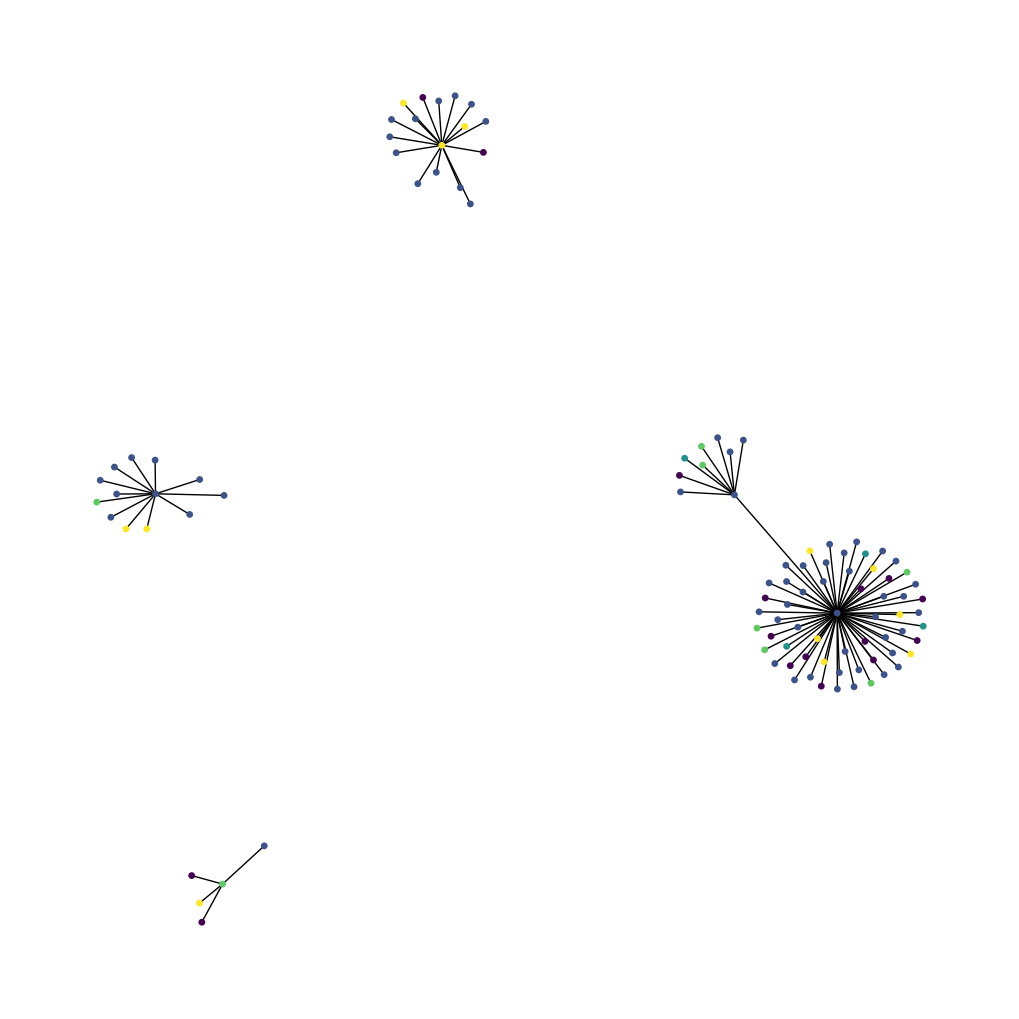

In [ ]:
plot = df.sample(n=100, random_state=1)
plt.figure(figsize=(10, 10))
colors = df["signal"].tolist()
G = nx.from_pandas_edgelist(plot, 'Date', 'tech', ['fund', 'sent', 'signal'])
subjects = list(df[df["Date"].isin(list(G.nodes))]["signal"])
nx.draw_spring(G, node_size=15, node_color=subjects)

In [ ]:
train_data, test_data = [], []

for _, group_data in df.groupby("signal"):
    # Select around 70% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.7
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (1915, 9)
Test data shape: (831, 9)


In [ ]:
test_data

,Date,Close,fundamental,fund,technical,tech,signal,sentiment,sent
2348,2348,1683.125000,7367.0,2,-27.267834,2,1,neutral,1
2606,2606,1679.550049,8314.0,2,-90.109562,0,4,neutral,1
1437,1437,510.109985,3450.0,2,-77.275820,2,1,neutral,1
331,331,63.520000,2214.0,2,-67.778672,2,1,neutral,1
1787,1787,830.445007,5374.0,2,-20.477899,2,1,neutral,1
...,...,...,...,...,...,...,...,...,...
1224,1224,375.019989,2775.0,2,-7.305479,4,3,neutral,1
2033,2033,515.799988,5994.0,2,-24.072513,2,1,neutral,1
11,11,59.104977,1890.0,1,-77.642095,2,1,neutral,1
1063,1063,229.809998,2775.0,2,-14.636094,3,0,neutral,1


Implement Train and Evaluate Experiment

In [ ]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

In [ ]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [ ]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

In [ ]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

Build a Baseline Neural Network Model

In [ ]:
feature_names = set(df[['technical', 'fundamental', 'sent']])
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()

# Create train and test targets as a numpy array.
y_train = train_data["signal"]
y_test = test_data["signal"]

x_train = np.array(x_train).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)

<ipython-input-36-bd323982c38f>:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x_train = train_data[feature_names].to_numpy()
<ipython-input-36-bd323982c38f>:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x_test = test_data[feature_names].to_numpy()


In [ ]:
print(num_features)
print(feature_names)
print(num_classes)
print(class_idx)

3
{'sent', 'technical', 'fundamental'}
5
{'buy': 0, 'neutral': 1, 'sell': 2, 'strong buy': 3, 'strong sell': 4}


In [ ]:
x_train

array([[ 1.0000000e+00, -5.1618999e+01,  8.3140000e+03],
       [ 1.0000000e+00, -1.2968127e+01,  1.8900000e+03],
       [ 1.0000000e+00, -3.0676041e+01,  5.3740000e+03],
       ...,
       [ 1.0000000e+00, -6.3518280e+01,  1.8900000e+03],
       [ 1.0000000e+00, -2.9622662e+01,  2.1910000e+03],
       [ 1.0000000e+00, -7.5815506e+01,  2.2140000e+03]], dtype=float32)

In [ ]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_features (InputLayer)    [(None, 3)]          0           []                               
                                                                                                  
 ffn_block1 (Sequential)        (None, 32)           1324        ['input_features[0][0]']         
                                                                                                  
 ffn_block2 (Sequential)        (None, 32)           2368        ['ffn_block1[0][0]']             
                                                                                                  
 skip_connection2 (Add)         (None, 32)           0           ['ffn_block1[0][0]',             
                                                                  'ffn_block2[0][0]']      

In [ ]:
history = run_experiment(baseline_model, x_train, y_train)

Epoch 1/300
7/7 [==============================] - 8s 108ms/step - loss: 2.0510 - acc: 0.5040 - val_loss: 2.0826 - val_acc: 0.1771
Epoch 2/300
7/7 [==============================] - 0s 21ms/step - loss: 1.4551 - acc: 0.5519 - val_loss: 1.6661 - val_acc: 0.1979
Epoch 3/300
7/7 [==============================] - 0s 18ms/step - loss: 1.2936 - acc: 0.5888 - val_loss: 1.5181 - val_acc: 0.2882
Epoch 4/300
7/7 [==============================] - 0s 23ms/step - loss: 1.1821 - acc: 0.6288 - val_loss: 1.3799 - val_acc: 0.3438
Epoch 5/300
7/7 [==============================] - 0s 21ms/step - loss: 1.1589 - acc: 0.6140 - val_loss: 1.2655 - val_acc: 0.4479
Epoch 6/300
7/7 [==============================] - 0s 18ms/step - loss: 1.1238 - acc: 0.6288 - val_loss: 1.1186 - val_acc: 0.5729
Epoch 7/300
7/7 [==============================] - 0s 17ms/step - loss: 1.0922 - acc: 0.6281 - val_loss: 1.0592 - val_acc: 0.6181
Epoch 8/300
7/7 [==============================] - 0s 17ms/step - loss: 1.0865 - acc: 0.6

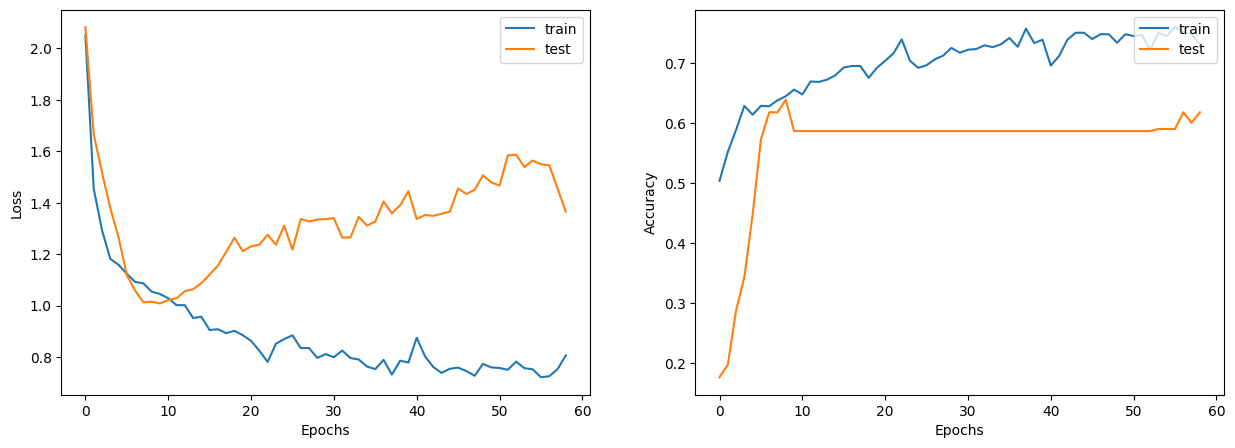

In [ ]:
display_learning_curves(history)

In [ ]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 58.97%


Examine the baseline model predictions

In [ ]:

def generate_random_instances(num_instances):
    token_probability = x_train.mean(axis=0)
    instances = []
    for _ in range(num_instances):
        probabilities = np.random.uniform(size=len(token_probability))
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)

    return np.array(instances)


def display_class_probabilities(probabilities):
    for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob * 100, 2)}%")


In [ ]:
new_instances = generate_random_instances(num_classes)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

1/1 [==============================] - 0s 418ms/step
Instance 1:
- buy: 18.53%
- neutral: 48.66%
- sell: 10.25%
- strong buy: 15.08%
- strong sell: 7.49%
Instance 2:
- buy: 18.53%
- neutral: 48.66%
- sell: 10.25%
- strong buy: 15.08%
- strong sell: 7.49%
Instance 3:
- buy: 18.53%
- neutral: 48.66%
- sell: 10.25%
- strong buy: 15.08%
- strong sell: 7.49%
Instance 4:
- buy: 18.53%
- neutral: 48.66%
- sell: 10.25%
- strong buy: 15.08%
- strong sell: 7.49%
Instance 5:
- buy: 18.53%
- neutral: 48.66%
- sell: 10.25%
- strong buy: 15.08%
- strong sell: 7.49%


Build a Graph Neural Network Model

In [ ]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = df[["tech","sent"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    df.sort_values("Date")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 2746)
Nodes shape: (2746, 3)


<ipython-input-91-593e57e7f69b>:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df.sort_values("Date")[feature_names].to_numpy(), dtype=tf.dtypes.float32


Implement a graph convolution layer

In [ ]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim]
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)

Implement a graph neural network node classifier

In [ ]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0,
        normalize=True,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)

In [ ]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()

GNN output shape: tf.Tensor(
[[-315.32547   -58.693245 -298.3903   -193.36047   -28.394554]
 [-318.47437   -59.42897  -307.3326   -193.60477   -27.385307]
 [-314.7118    -58.595505 -296.49982  -193.37363   -28.408295]], shape=(3, 5), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (2746, 32)                1324      
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 graph_conv2 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 postprocess (Sequential)    (2746, 32)                2368      
      

Train the model

In [ ]:
x_train = train_data.signal.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/300
7/7 [==============================] - 10s 276ms/step - loss: 2.1240 - acc: 0.0977 - val_loss: 1.5188 - val_acc: 0.5868
Epoch 2/300
7/7 [==============================] - 1s 114ms/step - loss: 1.5031 - acc: 0.4345 - val_loss: 1.4477 - val_acc: 0.5868
Epoch 3/300
7/7 [==============================] - 1s 122ms/step - loss: 1.2772 - acc: 0.6122 - val_loss: 1.4174 - val_acc: 0.5868
Epoch 4/300
7/7 [==============================] - 1s 97ms/step - loss: 1.4245 - acc: 0.5255 - val_loss: 1.4311 - val_acc: 0.5868
Epoch 5/300
7/7 [==============================] - 1s 80ms/step - loss: 1.1793 - acc: 0.6527 - val_loss: 1.3977 - val_acc: 0.5868
Epoch 6/300
7/7 [==============================] - 1s 77ms/step - loss: 1.1512 - acc: 0.6091 - val_loss: 1.3408 - val_acc: 0.5868
Epoch 7/300
7/7 [==============================] - 1s 78ms/step - loss: 0.9809 - acc: 0.6687 - val_loss: 1.3008 - val_acc: 0.5868
Epoch 8/300
7/7 [==============================] - 1s 78ms/step - loss: 1.3417 - acc: 

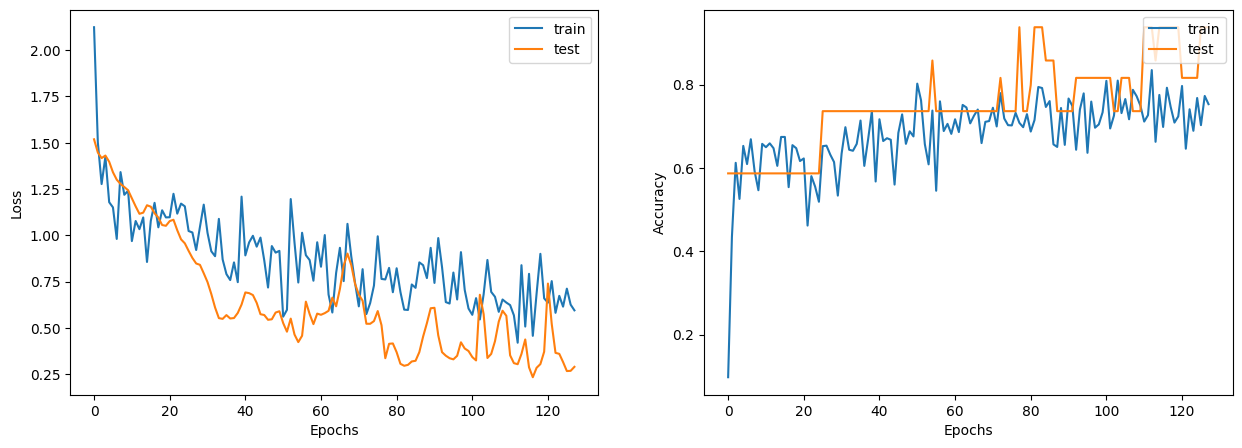

In [ ]:
display_learning_curves(history)

In [ ]:
x_test = test_data.signal.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 90.13%


Examine the model predictions

In [ ]:
# First we add the N new_instances as nodes to the graph
# by appending the new_instance to node_features.
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
# Second we add the M edges (citations) from each new node to a set
# of existing nodes in a particular subject
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in df.groupby("signal"):
    subject_papers = list(group.signal)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(df.signal), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

In [ ]:
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (2746, 3)
Original edges shape: (2, 2746)
New node_features shape: (2751, 3)
New edges shape: (2, 2781)
1/1 [==============================] - 1s 863ms/step
Instance 1:
- buy: 42.54%
- neutral: 57.46%
- sell: 0.0%
- strong buy: 0.0%
- strong sell: 0.0%
Instance 2:
- buy: 41.98%
- neutral: 58.02%
- sell: 0.0%
- strong buy: 0.0%
- strong sell: 0.0%
Instance 3:
- buy: 42.06%
- neutral: 57.93%
- sell: 0.0%
- strong buy: 0.0%
- strong sell: 0.0%
Instance 4:
- buy: 42.36%
- neutral: 57.64%
- sell: 0.0%
- strong buy: 0.0%
- strong sell: 0.0%
Instance 5:
- buy: 42.12%
- neutral: 57.88%
- sell: 0.0%
- strong buy: 0.0%
- strong sell: 0.0%


Thank you!